Challenge context
The data for this challenge have been generated by a real-world trial, whereby a suite of aids to understanding energy consumption was proposed to domestic electricity customers via an internet site. Energy usage by the sample of around 85000 households thus constituted was measured both before and after they gained access to this suite of aids. 

Challenge goals
The object of this challenge is to predict which of these clients actually reduced their consumption. Enhancing the accuracy of predictions allows for better targeting of clients, for a better fit between the advice given and the characteristics of the household, and ultimately for energy economies and improved customer satisfaction.

Data description
The data contains three types of information:
- Variables prefixed 'C' describing the client, the contract and the residence
- Variables prefixed 'S' detailing the client's use of the proposed aids: site visits, page views etc.
- Variables prefixed 'Q' containing the client's responses to questions concerning their electrical equipment, usage patterns, occupancy periods etc.
- and a binary variable : the target, indicating whether or not the client has made actual economies

In order to respect client confidentiality the data have been anonymised (each household is represented by an arbitrary unique identifier) and, for the most part, the exact meaning of the data has been masked. The data remains, nonetheless, real data with all of the quirks a data scientist expects to encounter regularly: diverse and varied data types (numerical, categorical, dates, Booleans), missing values, etc. It is down to the challenger to carry out any necessary data wrangling.

The first line of the source file (training_inputs.csv) is the header, columns are separated by semi-colons (;). A point (.) is used as decimal separator. 

The first three columns contain, respectively:
- ID: the client's unique identification number (one line = one client), it corresponds to the ID of the forecast in the target file
- COD_INSEE: the code of the municipality where the client lives, allocated by the French National Statistical Institute
- COD_IRIS: the code of the IRIS where the client lives (http://www.insee.fr/en/methodes/default.asp?page=definitions/iris.htm)

The training target file contains a binary target variable for each ID:
O = the ID has not made economies
1 = the ID has made economies
The first line of this file is the header, columns are separated by semi-colons (;).
The constituent columns are, respectively, the line's identification number (ID) and real target value (TARGET), as in the following example:

ID;TARGET
1;0
2;0
3;1
4;0
5;1
...

In [ ]:
!pip install -U imbalanced-learn

import os #for os.path.join
path = "/content/drive/MyDrive/Challenge SoGé"

Requirement already up-to-date: imbalanced-learn in /usr/local/lib/python3.6/dist-packages (0.7.0)


#Format des données

Nous avons des données sous un format tabulaire, chaque ligne étant associée à un label booléen. Les *features* sont de nature diverse : numériques, booléennes, calendaires, catégorielles.

On constate également que certaines données sont manquantes. Il faudra analyser la proportion et la répartition de ces données manquantes, ainsi que de vérifier la sensibilité de l'algorithme à des données NaN.



# Analyse des données

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

X = pd.read_csv(os.path.join(path, "training_inputs.csv"), header=0, sep=";")
X.set_index("ID", inplace=True)
y = pd.read_csv(os.path.join(path, "training_outputs.csv"), header=0, sep=";")
y.set_index("ID", inplace=True)

pd.set_option('display.max_rows', 120)

print(X)
print(X.dtypes)
print(y)

       COD_INSEE     COD_IRIS  C1  C2 C3  ...    Q71    Q72    Q73    Q74    Q75
ID                                        ...                                   
0        92025.0  920250102.0  EA  RA  C  ...  false  false    NaN    NaN    NaN
1        17359.0  173590000.0  EA  RA  C  ...  false  false   True  False  False
2        48156.0  481560000.0  EA  RC  B  ...  false  false    NaN    NaN    NaN
3        82125.0  821250000.0  EA  RA  C  ...  false  false    NaN    NaN    NaN
4        64422.0  644220102.0  EA  RA  B  ...  false  false    NaN    NaN    NaN
...          ...          ...  ..  .. ..  ...    ...    ...    ...    ...    ...
85524        NaN          NaN  EA  RA  C  ...   true   true    NaN    NaN    NaN
85525    74158.0  741580000.0  EA  RA  C  ...  false  false  False  False  False
85526    84007.0  840070114.0  EA  RA  B  ...  false  false    NaN    NaN    NaN
85527    83130.0  831300105.0  EA  RA  C  ...  false  false    NaN    NaN    NaN
85528    33281.0  332810301.

In [ ]:
ratio_shallow_rows = (X.shape[0] - X.dropna().shape[0]) / X.shape[0]
print(f"La proportion de lignes avec au moins un élément manquant est de {ratio_shallow_rows}.")

percent_missing = X.isnull().sum() * 100 / len(X)
print(percent_missing)

ratio_pos_labels = y[y['TARGET'] == 1].shape[0] / y.shape[0]
print(f"La proportion de classes positives est de {ratio_pos_labels:.3f}.")

La proportion de lignes avec au moins un élément manquant est de 1.0.
COD_INSEE     2.077658
COD_IRIS      2.019198
C1            0.000000
C2            0.000000
C3            0.000000
C4            0.000000
C5            0.000000
C6            0.000000
C7            0.000000
C8            0.000000
C9            0.000000
C10           0.000000
C11           0.000000
C12           0.000000
C13           0.000000
C14           0.000000
C15           0.000000
C16           0.000000
C17           0.000000
C18           0.000000
C19           0.000000
S1           31.405722
S2            0.000000
S3            0.000000
S4            0.000000
S5            0.000000
S6           31.405722
S7           31.405722
S8            0.000000
S9            0.000000
S10           0.000000
S11           0.000000
S12           0.000000
Q1            0.000000
Q2            0.009354
Q3            0.002338
Q4            0.002338
Q5            0.000000
Q6           67.807410
Q7           67.646062
Q8        

30


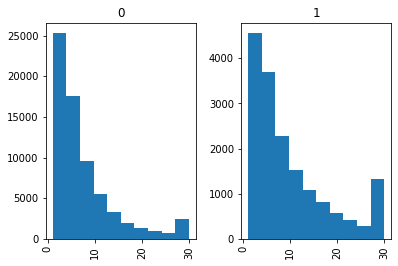

In [ ]:
X['S8'].hist(by=y['TARGET'])
print(max(X['S8']))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe76808ec88>,
      dtype=object)

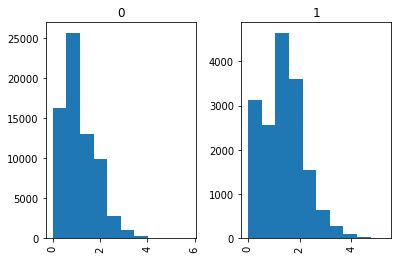

In [ ]:
np.log(X['S10'] + 1).hist(by=y['TARGET'])

La suppression des données incomplètes se révèle impossible. Si seulement une faible partie de ces données était incomplète, nous pourrions étudier leur éventuel biais par rapport à la prédiction avant de les supprimer ou pas.

La proportion de classes positives est sensiblement plus faible que 50%, ce qui nous amènera à réfléchir à deux points :
- durant l'apprentissage : éventuellement ré-équilibrer les données en entrée,
- après l'inférence et sur les résultats : utiliser une métrique appropriée pour analyser les résultats. 

# Pre-processing



Les données numériques peuvent être laissées telles quelles. De manière générale, les algorithmes utilisant des structures d'arbres (Random Forests, XGBoost) ne nécessitent pas de normalisation.

Les booléens peuvent être convertis en entiers (0 et 1) sans nécessité de faire appel à du one-hot-encoding étant donné que les splits des arbres de décision ont pour frontière des hyperplans orthogonaux aux *features*.

Les données textuelles semblent se rapporter à des catégories, que l'on peut convertir au format one-hot-encoding (créer plusieurs colonnes de 0 et de 1).

Parmi les données numériques, une question se pose sur la nature des codes INSEE et IRIS. Elles pourraient à la fois être considérées comme des variables catégorielles (car représentant une partition géographique) que numérique (régressive car des codes proches signifient probablement une proximité géographique). Néanmoins, les transformer via du one-hot-encoding serait difficile car ils sont très variés (augmentation non souhaitée de la dimensionnalité : pour discriminer un code particulier, des arbres plus profonds seront requis). Ici, nous pouvons les considérer comme des variables numériques standard, en se rapportant à l'hypothèse de régression géographique.

Concernant les données manquantes : TODO les dummy_na vont permettre à l'algorithme d'apprendre la répartition sous-jacente. TODO : ça va marcher ? Réfléchir dessus

TODO : les dates ??

In [ ]:
import re
from datetime import date

#On supprime les features avec plus de 50% de données manquantes
#X = X.drop(columns=['Q6', 'Q7', 'Q15', 'Q17', 'Q18', 'Q37', 'Q38', 'Q39', 'Q40', 'Q52'])
#Les variables HS
#X = X.drop(columns=['COD_INSEE', 'COD_IRIS'])

def convert_date(s):
    ref_date = date(2011, 1, 1)
    pattern = re.compile("^\d{4}\-(0[1-9]|1[012])\-(0[1-9]|[12][0-9]|3[01])$")
    if isinstance(s, str) and pattern.match(s):
        curr_date = date(int(s[0:4]), int(s[5:7]), int(s[8:10]))
        return (curr_date-ref_date).days #TODO check performances
        return int(s[5:7])
    else:
        return s

def get_season(month):
    dic = {1:'winter',2:'winter',3:'spring',4:'spring',5:'spring',6:'summer',7:'summer',8:'summer',9:'fall',10:'fall',11:'fall', 12:'winter'}
    if month in dic:
        return dic[month]

X = X.applymap(lambda x: x.strip().lower() if isinstance(x, str) else x)
X = X.applymap(lambda x: 1 if isinstance(x, str) and x == "true" else x)
X = X.applymap(lambda x: 0 if isinstance(x, str) and x == "false" else x)
X = X.applymap(lambda x: 1 if isinstance(x, bool) and x is True else x)
X = X.applymap(lambda x: 0 if isinstance(x, bool) and x is False else x)

X['S3_month'] = X['S3'].map(lambda x: int(x[5:7]) if not pd.isnull(x) else np.nan)
X['S3_month_sin'] = np.sin((X['S3_month']-1)*(2.*np.pi/12))
X['S3_month_cos'] = np.cos((X['S3_month']-1)*(2.*np.pi/12))
X['S3_season'] = X['S3_month'].apply(get_season)

X['S4_month'] = X['S4'].map(lambda x: int(x[5:7]) if not pd.isnull(x) else np.nan)
X['S4_month_sin'] = np.sin((X['S4_month']-1)*(2.*np.pi/12))
X['S4_month_cos'] = np.cos((X['S4_month']-1)*(2.*np.pi/12))
X['S4_season'] = X['S4_month'].apply(get_season)

X['S5_month'] = X['S5'].map(lambda x: int(x[5:7]) if not pd.isnull(x) else np.nan)
X['S5_month_sin'] = np.sin((X['S5_month']-1)*(2.*np.pi/12))
X['S5_month_cos'] = np.cos((X['S5_month']-1)*(2.*np.pi/12))
X['S5_season'] = X['S5_month'].apply(get_season)


X['S6_month'] = X['S6'].map(lambda x: int(x[5:7]) if not pd.isnull(x) else np.nan)
X['S6_month_sin'] = np.sin((X['S6_month']-1)*(2.*np.pi/12))
X['S6_month_cos'] = np.cos((X['S6_month']-1)*(2.*np.pi/12))
X['S6_season'] = X['S6_month'].apply(get_season)


X['S7_month'] = X['S7'].map(lambda x: int(x[5:7]) if not pd.isnull(x) else np.nan)
X['S7_month_sin'] = np.sin((X['S7_month']-1)*(2.*np.pi/12))
X['S7_month_cos'] = np.cos((X['S7_month']-1)*(2.*np.pi/12))
X['S7_season'] = X['S7_month'].apply(get_season)


X = X.applymap(convert_date) #reformat the dates

non_numerical_col_names = list(X.select_dtypes(exclude=["number"]).columns)

X = pd.get_dummies(X,
                   prefix=non_numerical_col_names,
                   columns=non_numerical_col_names,
                   dummy_na=True)

#X['COD_INSEE'] = X['COD_INSEE'].map(lambda x: x if (10000 < x < 99999) else np.nan)
#X['COD_IRIS'] = X['COD_IRIS'].map(lambda x: x if (100000000 < x < 999999999) else np.nan)

#X['COD_IRIS'] = X['COD_IRIS'] // 10000000 #truncate TODO check performances

'''X['bonusS65'] = X['S6'] - X['S5']
X['bonusS43'] = X['S4'] - X['S3']
X['bonusS54'] = X['S5'] - X['S4']
X['bonusS76'] = X['S7'] - X['S6']

X['bonus89'] = X['S8'] + X['S9']
X['bonus89prod'] = X['S8'] * X['S9']
X['bonus89min'] = X['S9'] - X['S8']
X['bonus89div'] = X['S9'] / X['S8']'''

'''X['S1_log'] = np.exp(X['S1'] + 1)
X['S2_log'] = np.exp(X['S2'] + 1)
X['S8_log'] = np.exp(X['S8'] + 1)
X['S9_log'] = np.exp(X['S9'] + 1)
X['S10_log'] = np.exp(X['S10'] + 1)
X['S11_log'] = np.exp(X['S11'] + 1)
X['S12_log'] = np.exp(X['S12'] + 1)'''



X['bonusiaibrc'] = X['C4_ib'] + X['C4_ia'] + X['C13_rc']
X['bonusiaibrc_prod'] = X['C4_ib'] * X['C4_ia'] * X['C13_rc']
X['bonuspdoc_prod'] = X['Q10_pd'] * X['C12_oc']
#X['bonus_S_sumlog'] = X['S1_log'] + X['S2_log'] + X['S8_log'] + X['S9_log'] + X['S10_log'] + X['S11_log'] + X['S12_log']

#false_columns = [col for col in X.columns if "false" in col]
#X = X.drop(columns=false_columns)

In [ ]:
# Small checks

for i in X.columns:
    print(i)

COD_INSEE
COD_IRIS
C5
C6
C7
C10
C11
C15
C16
C17
C18
C19
S1
S2
S3
S4
S5
S6
S7
S8
S9
S10
S11
S12
Q4
Q5
Q6
Q7
Q8
Q9
Q13
Q14
Q15
Q16
Q17
Q18
Q19
Q20
Q21
Q22
Q23
Q24
Q25
Q26
Q27
Q30
Q31
Q33
Q35
Q37
Q38
Q40
Q41
Q42
Q43
Q44
Q45
Q46
Q47
Q48
Q49
Q50
Q51
Q52
Q53
Q54
Q55
Q56
Q57
Q58
Q59
Q60
Q61
Q62
Q63
Q64
Q65
Q66
Q67
Q68
Q69
Q70
Q71
Q72
Q73
Q74
Q75
S3_month
S3_month_sin
S3_month_cos
S4_month
S4_month_sin
S4_month_cos
S5_month
S5_month_sin
S5_month_cos
S6_month
S6_month_sin
S6_month_cos
S7_month
S7_month_sin
S7_month_cos
C1_ea
C1_nan
C2_r7
C2_ra
C2_rb
C2_rc
C2_nan
C3_a
C3_b
C3_c
C3_d
C3_e
C3_f
C3_g
C3_h
C3_i
C3_nan
C4_ia
C4_ib
C4_nan
C8_ya
C8_yb
C8_nan
C9_ra
C9_rb
C9_nan
C12_o7
C12_oa
C12_ob
C12_oc
C12_nan
C13_r7
C13_ra
C13_rb
C13_rc
C13_rd
C13_nan
C14_oa
C14_ob
C14_nan
Q1_h7
Q1_ha
Q1_hb
Q1_hc
Q1_nan
Q2_z7
Q2_za
Q2_zb
Q2_zc
Q2_nan
Q3_u7
Q3_ua
Q3_ub
Q3_uc
Q3_nan
Q10_p7
Q10_pa
Q10_pb
Q10_pc
Q10_pd
Q10_pe
Q10_nan
Q11_d0
Q11_d1
Q11_d3
Q11_d4
Q11_d5
Q11_d7
Q11_d8
Q11_d9
Q11_da
Q11_db
Q11_dc
Q11_dd
Q11

In [ ]:
# Constitution du training set et du testing set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True)

# On passe tout au format Numpy
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy().ravel()
y_test = y_test.to_numpy().ravel()

In [ ]:
print(X_train.shape)
print(y_train.shape)

(72699, 301)
(72699,)


# XGBoost

In [ ]:
import xgboost as xgb
import tensorflow as tf
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import Normalizer

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer

'''print(np.isnan(np.min(X_train)))

#Dummify (remove NaN and replace by mean)
X_train_dummy = np.copy(X_train)
X_test_dummy = np.copy(X_test)

col_mean_train = np.nanmean(X_train, axis=0)
inds_train = np.where(np.isnan(X_train))
X_train_dummy[inds_train] = np.take(col_mean_train, inds_train[1])
inds_test = np.where(np.isnan(X_test))
X_test_dummy[inds_test] = np.take(col_mean_train, inds_test[1]) #We fill with the mean of the training set

from sklearn.decomposition import PCA

pca = PCA(n_components=20)
normalizer = Normalizer()
X_train_dummy = normalizer.fit_transform(X_train_dummy)
X_test_dummy = normalizer.transform(X_test_dummy)

X_train_dummy_PCA = pca.fit_transform(X_train_dummy)
X_test_dummy_PCA = pca.transform(X_test_dummy)
print(pca.explained_variance_ratio_)'''

imputer = SimpleImputer(strategy="mean")
X_train_imp = imputer.fit_transform(X_train)
X_test_imp = imputer.transform(X_test)

print(X_train_imp.shape)

from imblearn.over_sampling import SMOTE
s = SMOTE()
X_train_smoted, y_train_smoted = s.fit_resample(X_train_imp, y_train) #TODO not used, doesn't work well

(72699, 301)


In [ ]:
print(X_train.shape)

(72699, 269)


In [ ]:
y[y['TARGET'] == 0].shape[0] / y[y['TARGET'] == 1].shape[0]

4.165418528807827

In [ ]:
#XGBoost

with tf.device('/device:GPU:0'):

    '''classifier = xgb.XGBClassifier(n_estimators=500, max_depth=4, missing=np.nan, nthread=-1,
                        objective='binary:logistic', sampling_method='gradient_based', min_child_weight=0.25,
                        subsample=0.85,reg_lambda=1.5, reg_alpha=2.5, tree_method='gpu_hist', learning_rate=0.1, colsample_bytree=0.7,
                        scale_pos_weight=y[y['TARGET'] == 0].shape[0] / y[y['TARGET'] == 1].shape[0], silent=True)'''
    
    classifier = xgb.XGBClassifier(n_estimators=5000, max_depth=5, missing=np.nan, nthread=-1,
                        objective='binary:logistic', sampling_method='gradient_based',
                        subsample=0.5,reg_lambda=2.5, reg_alpha=2.5, tree_method='gpu_hist', learning_rate=0.02, colsample_bytree=0.1, colsample_bylevel=1.0, min_child_weight=3,
                        scale_pos_weight=y[y['TARGET'] == 0].shape[0] / y[y['TARGET'] == 1].shape[0], silent=True)
  
    '''parameters = {"colsample_bytree": [0.5, 0.7,0.85,1],
                  "subsample": [0.5, 0.7, 0.85, 1],
                  "min_child_weight": [0.1, 0.25, 0.5, 0.75, 1],
                  "max_depth": [4,5,6,7,8,9,10],
               "reg_lambda": [0, 0.5,1,1.5,2,2.5],
               "reg_alpha": [0, 0.5,1,1.5,2,2.5],
                "n_estimators":[100,300,500,800],
                "learning_rate":[0.001,0.01,0.1,0.2]}'''
    parameters = {"max_depth":[3,4,5,6,7,8,9,10],
                  "learning_rate":[0.001,0.01,0.1,0.2],
                  "scale_pos_weight":[3.5,4,4.5,5],
                  "n_estimators":[100,500,800]}

    '''xgb_rscv = RandomizedSearchCV(classifier, param_distributions=parameters, scoring="f1",
                             cv=5, verbose=2)
 
    boost_fit = xgb_rscv.fit(X_train, y_train)

    print("Best Score: {}".format(boost_fit.best_score_))
    print("Best params: {}".format(boost_fit.best_params_))'''

    early_stopping_rounds=15
    eval_set = [(X_train, y_train), (X_test, y_test)]
    classifier.fit(X_train,y_train, early_stopping_rounds=15, eval_metric=["auc"], eval_set=eval_set, verbose=True)

    #classifier.fit(X_train, y_train)

[0]	validation_0-auc:0.607898	validation_1-auc:0.602722
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 15 rounds.
[1]	validation_0-auc:0.66099	validation_1-auc:0.651465
[2]	validation_0-auc:0.680655	validation_1-auc:0.674018
[3]	validation_0-auc:0.681399	validation_1-auc:0.674688
[4]	validation_0-auc:0.685719	validation_1-auc:0.677648
[5]	validation_0-auc:0.687526	validation_1-auc:0.681019
[6]	validation_0-auc:0.68909	validation_1-auc:0.682265
[7]	validation_0-auc:0.694349	validation_1-auc:0.686946
[8]	validation_0-auc:0.695627	validation_1-auc:0.687472
[9]	validation_0-auc:0.6999	validation_1-auc:0.690934
[10]	validation_0-auc:0.701831	validation_1-auc:0.692524
[11]	validation_0-auc:0.702525	validation_1-auc:0.692783
[12]	validation_0-auc:0.707341	validation_1-auc:0.696948
[13]	validation_0-auc:0.71041	validation_1-auc:0.700116
[14]	validation_0-auc:0.711783	validation_1-auc:0.701691
[15

On training
Training f1-score is 0.0
Training average precision is 0.0
Training average recall is 0.0


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


On testing
Testing f1-score is 0.0
Testing average precision is 0.0
Testing average recall is 0.0


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


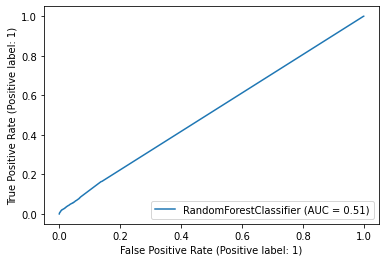

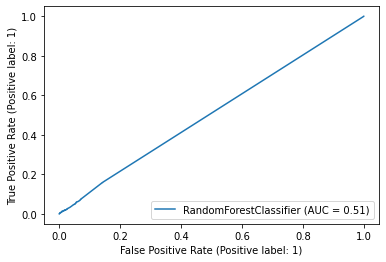

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA

normalizer = Normalizer()
X_train_imp_norm = normalizer.fit_transform(X_train_imp)
X_test_imp_norm = normalizer.transform(X_test_imp)

pca = PCA()
X_train_imp_norm_pca = pca.fit_transform(X_train_imp_norm)
X_test_imp_norm_pca = pca.transform(X_test_imp_norm)

classifier = RandomForestClassifier(n_estimators=600, max_depth=4)

classifier.fit(X_train_imp_norm,y_train)

from sklearn.metrics import accuracy_score, f1_score, plot_roc_curve, precision_score, recall_score

print("On training")

y_pred_on_train = classifier.predict(X_train_imp_norm)
print(f"Training f1-score is {f1_score(y_pred_on_train, y_train)}")
print(f"Training average precision is {precision_score(y_pred_on_train, y_train)}")
print(f"Training average recall is {recall_score(y_pred_on_train, y_train)}")


plot_roc_curve(classifier, X_train_imp_norm, y_train)

print("On testing")

y_pred = classifier.predict(X_test_imp_norm)
print(f"Testing f1-score is {f1_score(y_pred, y_test)}")
print(f"Testing average precision is {precision_score(y_pred, y_test)}")
print(f"Testing average recall is {recall_score(y_pred, y_test)}")

plot_roc_curve(classifier, X_test_imp_norm, y_test)

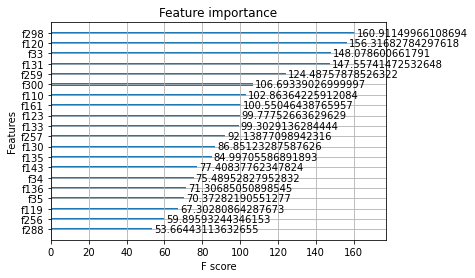

bonusiaibrc: gain 160.91149966108694
C4_ib: gain 156.31682784297618
Q16: gain 148.078600661791
C12_oc: gain 147.55741472532648
Q34_ef: gain 124.48757878526322
bonuspdoc_prod: gain 106.69339026999997
C3_b: gain 102.86364225912084
Q10_pd: gain 100.55046438765957
C8_yb: gain 99.77752663629629
C13_r7: gain 99.3029136284444
Q34_ed: gain 92.13877098942316
C12_ob: gain 86.85123287587626
C13_rb: gain 84.99705586891893
Q1_ha: gain 77.40837762347824
Q17: gain 75.48952827952832
C13_rc: gain 71.30685050898545
Q18: gain 70.37282190551277
C4_ia: gain 67.30280864287673
Q34_ec: gain 59.89593244346153
S6_season_fall: gain 53.66443113632655
Q10_pc: gain 51.82631812224299
S3_season_fall: gain 48.592079409677424
C8_ya: gain 45.570949941960784
S6_month_sin: gain 45.24406732144506
S5_month: gain 39.80206255316242
S8: gain 39.68749249158574
Q52: gain 38.381873137659575
Q11_d3: gain 38.02562973083334
S3_season_spring: gain 37.547784852142854
S7_season_nan: gain 37.446190318571425
C12_oa: gain 35.6474513046666

In [ ]:
#classifier.get_booster().get_score(importance_type="gain")

import matplotlib.pyplot as plt

from xgboost import plot_importance
plot_importance(classifier, max_num_features=20, importance_type="gain") # top 20 most important features
plt.show()

importances = classifier.get_booster().get_score(importance_type='gain')
importances_sorted = {k: v for k, v in sorted(importances.items(), key=lambda item: item[1], reverse=True)}
c = 0
for key in importances_sorted:
    print(f"{X.columns[int(key[1:])]}: gain {importances_sorted[key]}")
    c+=1
print(c)

On training
Training f1-score is 0.4843956043956044
Training average precision is 0.7453898184407263
Training average recall is 0.3587731322823852
On testing
Testing f1-score is 0.4425354679161785
Testing average precision is 0.6764822920811778
Testing average recall is 0.3288201160541586


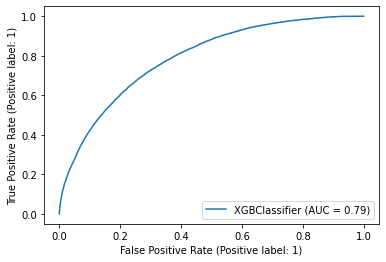

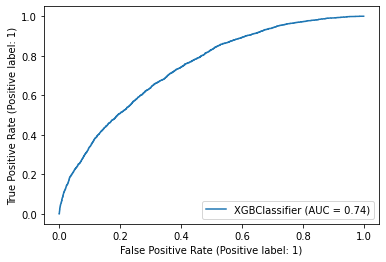

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, plot_roc_curve, precision_score, recall_score

print("On training")

y_pred_on_train = classifier.predict(X_train)
print(f"Training f1-score is {f1_score(y_pred_on_train, y_train)}")
print(f"Training average precision is {precision_score(y_pred_on_train, y_train)}")
print(f"Training average recall is {recall_score(y_pred_on_train, y_train)}")


plot_roc_curve(classifier, X_train, y_train)

print("On testing")

y_pred = classifier.predict(X_test)
print(f"Testing f1-score is {f1_score(y_pred, y_test)}")
print(f"Testing average precision is {precision_score(y_pred, y_test)}")
print(f"Testing average recall is {recall_score(y_pred, y_test)}")



plot_roc_curve(classifier, X_test, y_test)

In [ ]:
#SVM (non-linear)

Extension : comment gérer de nouvelles variables ou de nouvelles catégories parmi les variables correspondantes ?